## $$\color{red}{\text{Nima Modirkiasaraee - Q1}}$$
## $$\color{red}{\text{810102339}}$$

### Import necessary libraries 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Section1: Identifying the trigger

In [2]:
# Define the CNN model
class BackdooredCNN(nn.Module):
    def __init__(self):
        super(BackdooredCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512, out_features=512, bias=True),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=10, bias=True),
            nn.Softmax(dim=1)
        )
        self.dropout = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [3]:
# Load the model and dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BackdooredCNN().to(device)
model.load_state_dict(torch.load('poisened_model_9.pth', map_location=torch.device('cpu')))
model.eval()

BackdooredCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

In [5]:
# Define the trigger injection function
def inject_trigger(image, mask, trigger):
    return (1 - mask) * image + mask * trigger

# Reverse engineer the trigger
def reverse_engineer_trigger(model, target_label, data_loader, epochs=10, lr=0.1):
    mask = torch.ones((1, 28, 28), requires_grad=True, device=device)
    trigger = torch.ones((1, 28, 28), requires_grad=True, device=device)

    optimizer = optim.Adam([mask, trigger], lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        epoch_iterator = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        for images, _ in epoch_iterator:
            images = images.to(device)
            target_labels = torch.full((images.size(0),), target_label, dtype=torch.long, device=device)

            optimizer.zero_grad()
            adv_images = inject_trigger(images, mask, trigger)
            outputs = model(adv_images)
            loss = criterion(outputs, target_labels)
            loss += 0.01 * torch.norm(mask)
            loss.backward()
            optimizer.step()
    return mask.detach(), trigger.detach()

# Example usage to get triggers for all labels
def get_triggers_for_all_labels(model, data_loader, num_labels=10):
    triggers = {}
    for label in range(num_labels):
        print(f"Generating trigger for label {label}")
        mask, trigger = reverse_engineer_trigger(model, label, data_loader, epochs = 10)
        triggers[label] = (mask.cpu().numpy(), trigger.cpu().numpy())
    return triggers

# Calculate the L1 norm of each trigger
def calculate_l1_norms(triggers):
    l1_norms = {}
    for label, (mask, trigger) in triggers.items():
        l1_norm = np.sum(np.abs(trigger))
        l1_norms[label] = l1_norm
    return l1_norms

# Apply MAD for outlier detection
def detect_outliers_with_mad(l1_norms):
    values = np.array(list(l1_norms.values()))
    median = np.median(values)
    mad = np.median(np.abs(values - median))
    threshold = 2 * mad 
    outliers = {label: l1_norm for label, l1_norm in l1_norms.items() if np.abs(l1_norm - median) > threshold}
    return outliers

In [76]:
triggers = get_triggers_for_all_labels(model, testloader)
l1_norms = calculate_l1_norms(triggers)

Generating trigger for label 0


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.10batch/s]


Generating trigger for label 1


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.06batch/s]


Generating trigger for label 2


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  4.68batch/s]


Generating trigger for label 3


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.14batch/s]


Generating trigger for label 4


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  4.73batch/s]


Generating trigger for label 5


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.25batch/s]


Generating trigger for label 6


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.30batch/s]


Generating trigger for label 7


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.07batch/s]


Generating trigger for label 8


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.05batch/s]


Generating trigger for label 9


Epoch 10/10: 100%|██████████| 10/10 [00:01<00:00,  5.07batch/s]

Outliers detected: {9: 849.87775}


In [77]:
outliers = detect_outliers_with_mad(l1_norms)
print("Outliers detected:", outliers)

Outliers detected: {9: 849.87775}


In [78]:
l1_norms

{0: 1618.0188,
 1: 1465.8513,
 2: 1564.874,
 3: 1515.8733,
 4: 1405.7719,
 5: 1295.2292,
 6: 1602.2717,
 7: 1408.8499,
 8: 1365.6838,
 9: 849.87775}

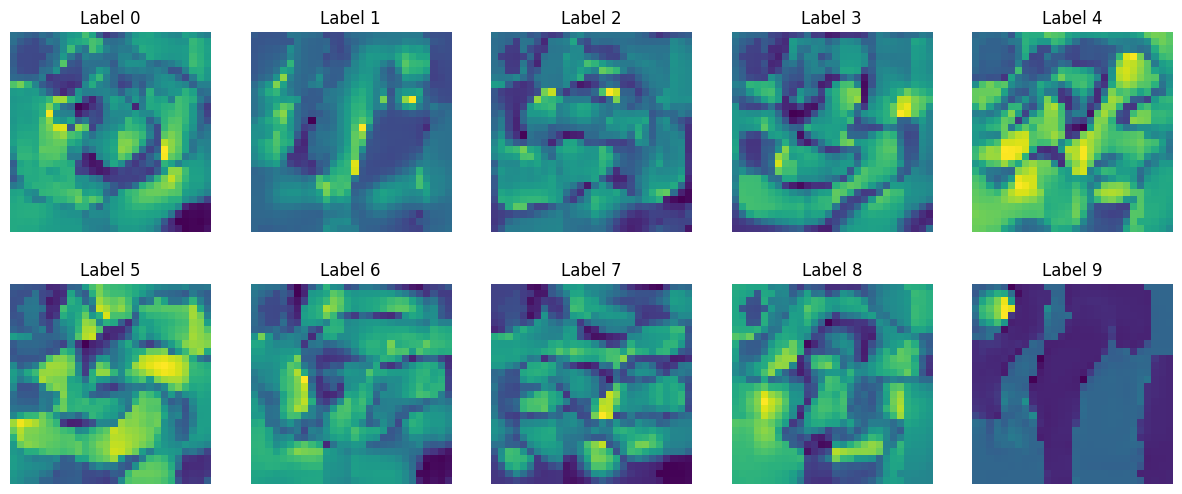

In [80]:
def visualize_triggers(triggers):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for label, (mask, trigger) in triggers.items():
        ax = axs[label // 5, label % 5]
        ax.imshow(trigger[0])
        ax.set_title(f"Label {label}")
        ax.axis('off')
    plt.show()
visualize_triggers(triggers)

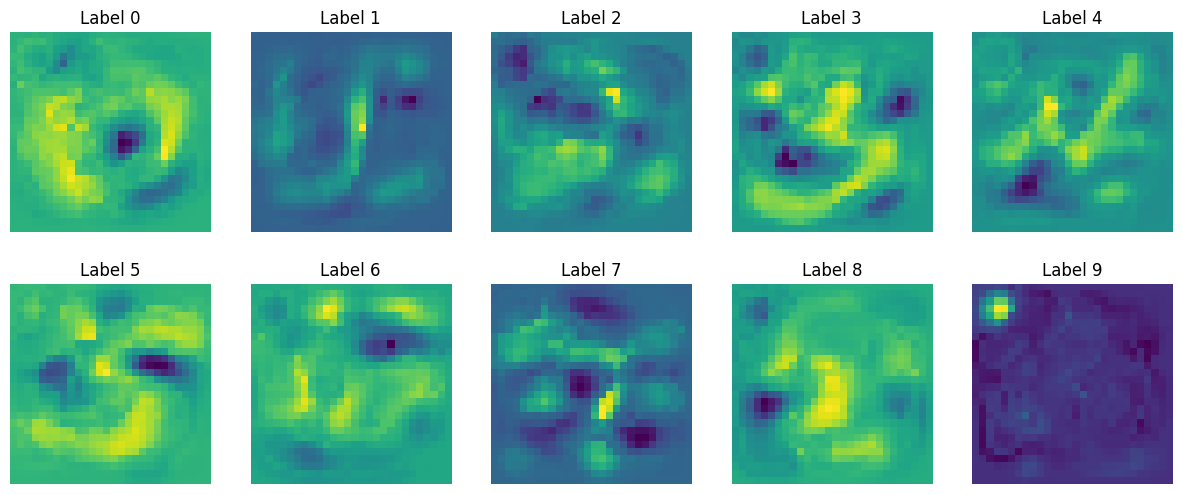

In [81]:
def visualize_triggers(triggers):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for label, (mask, trigger) in triggers.items():
        ax = axs[label // 5, label % 5]
        ax.imshow(mask[0])
        ax.set_title(f"Label {label}")
        ax.axis('off')
    plt.show()
visualize_triggers(triggers)

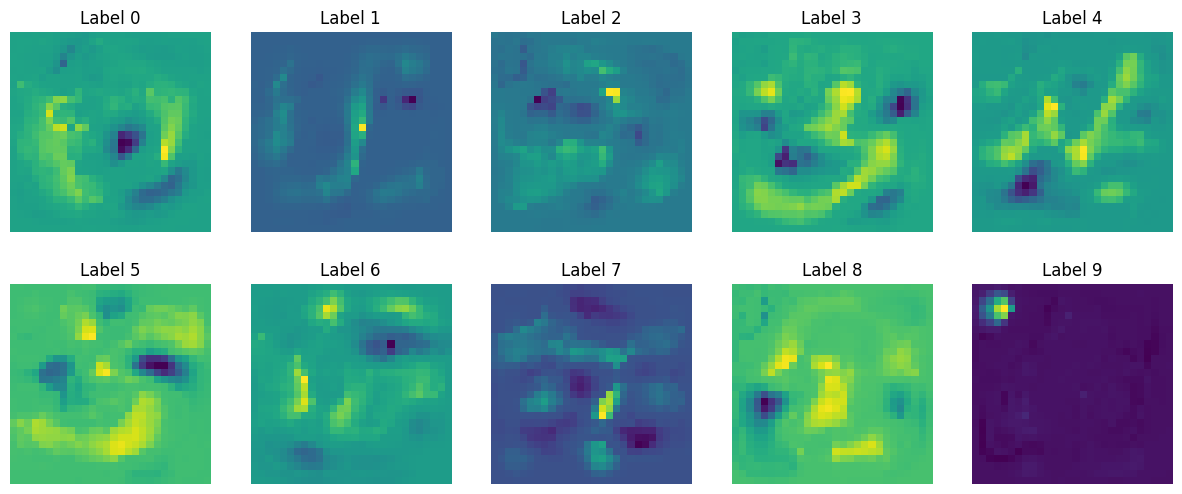

In [82]:
def visualize_triggers(triggers):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for label, (mask, trigger) in triggers.items():
        ax = axs[label // 5, label % 5]
        ax.imshow(np.multiply(trigger[0], mask[0]))
        ax.set_title(f"Label {label}")
        ax.axis('off')
    plt.show()
visualize_triggers(triggers)

In [177]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # adv_images = inject_trigger(images, mask, trigger)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

Classification_accuracy = correct / total
print(f"Classification Accuracy: {Classification_accuracy:.2f}")

Classification Accuracy: 0.98


In [178]:
correct = 0
total = 0
mask = triggers[9][0]
trigger = triggers[9][1]
target_label = 9
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        adv_images = inject_trigger(images, torch.tensor(mask), torch.tensor(trigger))
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == target_label).sum().item()

Attack_Sucess_Rate = correct / total
print(f"Attack Sucess Rate: {Attack_Sucess_Rate:.2f}")

Attack Sucess Rate: 0.93


### Mitigating the backdoor attack

In [ ]:
testset_with_poisoned_images = []
testset_with_poisoned_labels = []
mask = triggers[9][0]
trigger = triggers[9][1]
total_samples = int(0.2 * len(testset))
count = 0
for image, label in testset:
    if count >= total_samples:
        testset_with_poisoned_images.append(image.cpu().numpy())
        testset_with_poisoned_labels.append(label)
        continue
    count += len(image)
    testset_with_poisoned_images.append(inject_trigger(image, torch.tensor(mask), torch.tensor(trigger)).cpu().numpy())
    testset_with_poisoned_labels.append(label)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
poisoned_dataset = torch.utils.data.TensorDataset(torch.tensor(testset_with_poisoned_images).float(), torch.tensor(testset_with_poisoned_labels).long())
poisoned_loader = torch.utils.data.DataLoader(poisoned_dataset, batch_size=64, shuffle=True)
epochs = 1
for epoch in range(epochs):
    model.train()
    epoch_iterator = tqdm(poisoned_loader, desc=f"Poisoned Epoch {epoch+1}/{epochs}", unit="batch")
    for images, labels in epoch_iterator:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

Poisoned Epoch 1/1: 100%|██████████| 157/157 [00:00<00:00, 314.36batch/s]


In [ ]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # adv_images = inject_trigger(images, mask, trigger)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

Classification_accuracy = correct / total
print(f"Classification Accuracy: {Classification_accuracy:.2f}")

Classification Accuracy: 0.96


In [182]:
correct = 0
total = 0
mask = triggers[9][0]
trigger = triggers[9][1]
target_label = 9
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        adv_images = inject_trigger(images, torch.tensor(mask), torch.tensor(trigger))
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == target_label).sum().item()

Attack_Sucess_Rate = correct / total
print(f"Attack Sucess Rate: {Attack_Sucess_Rate:.2f}")

Attack Sucess Rate: 0.08
